In [1]:
import re
import json
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns

# NLTK Stop words
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# spacy for lemmatization
import spacy

#remove urls, mentions, emojis 
import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [2]:
filepath = '/Users/lavine/Desktop/Terriers!/misinformation project/data/data.txt'

### Create a dataframe by every columns

In [3]:
#load all the JSON objects in one list as dictionaries
data = []
with open(filepath,'r') as f:
    for line in f:
        data.append(json.loads(line))

In [11]:
data[2]['referenced_tweets'][0]['text']

"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔"

In [13]:
data[4]['referenced_tweets']

[{'type': 'retweeted',
  'id': '1476696095963058177',
  'lang': 'en',
  'possibly_sensitive': False,
  'author_id': '2181341294',
  'text': '@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3',
  'entities': {'annotations': [{'start': 85,
     'end': 96,
     'probability': 0.581,
     'type': 'Organization',
     'normalized_text': 'Exxon Mobile'}],
   'urls': [{'start': 225,
     'end': 248,
     'url': 'https://t.co/WPetiWDQG3',
     'expanded_url': 'http://Exxonknew.org',
     'display_url': 'Exxonknew.org'}],
   'mentions': [{'start': 0,
     'end': 13,
     'username': 'ScottGrimnes',
     'id': '847597746043342848',
     'verified': False,
     'created_at': '2017-03-30T23:53:45.000Z',
     'location': 'Arizona, USA',
     'public_metrics': {'followers_count': 357,
      'following_co

 #### Put the text data in one list

not original:
referenced_tweet in i:
 == retweet 
 
lst_


original:
if not 'referenced_tweets' in i

lst_o_text.append(i['text'])



#retrive text and avoid truncated text when retweet without quoting
lst_o_text = []
lst_ret_text = []
lst_rep_text = []

for i in data:    
    if 'referenced_tweets' in i:
        if i['referenced_tweets'][0]['type'] != 'retweeted':
            lst_text.append(i['referenced_tweets'][0]['text'])
        else:
            lst_text.append(i['text'])
    else:
        lst_text.append(i['text'])

In [15]:
lst_o_text = []

for i in data:
    if not 'referenced_tweets' in i:
        lst_o_text.append(i['text'])

 #### Put the author info in list

In [8]:
data[0].keys()

dict_keys(['lang', 'id', 'possibly_sensitive', 'author_id', 'text', 'referenced_tweets', 'created_at', 'source', 'entities', 'in_reply_to_user_id', 'reply_settings', 'conversation_id', 'public_metrics', 'author', 'in_reply_to_user', '__twarc'])

 ##### 'id', 'author_id', 'conversation_id', 'author'

In [9]:
#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []
for i in data:
    lst_id.append(i['id'])
    lst_lang.append(i['lang'])
    lst_author_id.append(i['author_id'])
    lst_conversation_id.append(i['conversation_id'])

There are too much info in author dictionary

In [11]:
#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []
for i in data:
    lst_author_verified.append(i['author']['verified'])
    lst_author_name.append(i['author']['name'])
    lst_author_username.append(i['author']['username'])

 ##### Make creation time

In [12]:
#list creation time
lst_twt_creation_time = []
for i in data:
    lst_twt_creation_time.append(i['created_at'])

##### Put what we have in one dataframe

lst_text,lst_id, lst_author_id,lst_conversation_id,lst_author_verified, lst_author_name, lst_author_username,lst_twt_creation_time

In [13]:
tweets = pd.DataFrame({'text': lst_o_text,
                  'language': lst_lang,
                  'id': lst_id,
                  'author_id': lst_author_id,
                  'conversation_id': lst_conversation_id,
                  'author_verified': lst_author_verified,
                  'author_name': lst_author_name,
                  'author_username': lst_author_username,
                  'twt_creation_time': lst_twt_creation_time
                  })

In [14]:
pd.set_option("display.max_colwidth", 10000)

In [15]:
tweets.drop(tweets[tweets['language'] != 'en'].index, inplace = True)

In [16]:
tweets.head()

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time
2,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477059914015125507,2732778706,1477059914015125507,False,Tai Chi,TaiWendysb,2021-12-31T23:31:40.000Z
3,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477056800889323523,414239235,1477056800889323523,False,Richard Estes,oshima9,2021-12-31T23:19:18.000Z
4,@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3,en,1477046502400868359,824946672673361920,1477046502400868359,False,Kris,writing_callous,2021-12-31T22:38:23.000Z
5,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477040827503362057,2429328178,1477040827503362057,False,David💙l🇪🇺#FindMissyandBiscuit,David96212152,2021-12-31T22:15:50.000Z
6,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477035647462363141,795750344970141701,1476641658636693513,False,☭🇵🇸🇾🇪🇸🇾,zia_kat,2021-12-31T21:55:15.000Z


### Data preprocessing

In [17]:
tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [18]:
#forming a separate feature for cleaned tweets
tweets['ctext'] = tweets['text'].apply(lambda x: p.clean(x))

In [19]:
tweets.head(3)

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext
2,"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose. 😔",en,1477059914015125507,2732778706,1477059914015125507,False,Tai Chi,TaiWendysb,2021-12-31T23:31:40.000Z,[],"I'm thinking about writing a satire where the U.S. Congress is blocked from taking action on the climate by a Senator who owns a coal company, lives on a yacht and speaks daily with Exxon lobbyists -- but I'm worried people will think it's too on the nose."
3,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477056800889323523,414239235,1477056800889323523,False,Richard Estes,oshima9,2021-12-31T23:19:18.000Z,[],"no, capitalists are the cause."
4,@ScottGrimnes @MaMan564 @SoFarFletched ‘We’ started calling it ‘climate change’ when Exxon Mobile did a very successful PR campaign in the 90’s. Apparently ‘global warming’ is too specific and scary. But It’s global warming. https://t.co/WPetiWDQG3,en,1477046502400868359,824946672673361920,1477046502400868359,False,Kris,writing_callous,2021-12-31T22:38:23.000Z,[],We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s. Apparently global warming is too specific and scary. But Its global warming.


,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext
3,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477056800889323523,414239235,1477056800889323523,False,Richard Estes,oshima9,2021-12-31T23:19:18.000Z,[],"no, capitalists are the cause."
6,"@Mum2Mrs @oshima9 no, capitalists are the cause.\nhttps://t.co/VyFfKhY2Yp",en,1477035647462363141,795750344970141701,1476641658636693513,False,☭🇵🇸🇾🇪🇸🇾,zia_kat,2021-12-31T21:55:15.000Z,[],"no, capitalists are the cause."


,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext


In [20]:
#convert to list
ctext = tweets['ctext'].tolist()

In [21]:
# Remove new line characters
ctext = [re.sub('\s+', ' ', sent) for sent in ctext]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_25328/1351202947.py:2: DeprecationWarning: invalid escape sequence \s
  ctext = [re.sub('\s+', ' ', sent) for sent in ctext]


In [22]:
# Remove distracting single quotes
ctext = [re.sub("\'", "", sent) for sent in ctext]

In [23]:
# remove punctuations
ctext = [re.sub(r'[^\w\s]', '', sent) for sent in ctext]

In [24]:
ctext[1:5]

['no capitalists are the cause',
 'We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s Apparently global warming is too specific and scary But Its global warming',
 'Im thinking about writing a satire where the US Congress is blocked from taking action on the climate by a Senator who owns a coal company lives on a yacht and speaks daily with Exxon lobbyists  but Im worried people will think its too on the nose',
 'no capitalists are the cause']

### Tokenize words and further clean up text

In [25]:
#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altoghter

In [26]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tweet_words = list(sent_to_words(ctext))

print(tweet_words[:1])

[['im', 'thinking', 'about', 'writing', 'satire', 'where', 'the', 'us', 'congress', 'is', 'blocked', 'from', 'taking', 'action', 'on', 'the', 'climate', 'by', 'senator', 'who', 'owns', 'coal', 'company', 'lives', 'on', 'yacht', 'and', 'speaks', 'daily', 'with', 'exxon', 'lobbyists', 'but', 'im', 'worried', 'people', 'will', 'think', 'its', 'too', 'on', 'the', 'nose']]


In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tweet_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tweet_words[0]]])

['im', 'thinking', 'about_writing_satire', 'where', 'the', 'us', 'congress', 'is', 'blocked', 'from', 'taking', 'action', 'on', 'the', 'climate', 'by', 'senator', 'who', 'owns', 'coal', 'company', 'lives', 'on', 'yacht', 'and', 'speaks', 'daily', 'with', 'exxon', 'lobbyists', 'but', 'im', 'worried', 'people', 'will', 'think', 'its', 'too', 'on', 'the', 'nose']


### Remove Stopwords, Make Bigrams and Lemmatize

In [28]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'm'])

In [29]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [30]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [31]:
# Remove Stop Words
tweet_words_nostops = remove_stopwords(tweet_words)

In [32]:
# Form Bigrams
tweet_words_bigrams = make_bigrams(tweet_words_nostops)

In [33]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])# not "en" any more

# Do lemmatization keeping only noun, adj, vb, adv
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tweet_lemmatized[:1])

[['m', 'think', 'block', 'take', 'action', 'climate', 'senator', 'own', 'coal', 'company', 'live', 'yacht', 'speak', 'daily', 'lobbyist', 'm', 'worried', 'people', 'think', 'nose']]


### Creat the dictionary and the corpus

In [34]:
# Create Dictionary
id2word = corpora.Dictionary(tweet_lemmatized)

# Create Corpus
texts = tweet_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] 

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown below is a mapping of (word_id, word_frequency(times of occurance)).

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1)]]


In [35]:
id2word[40]

'environment'

In [36]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[4]

#in put of LDA

'company'

In [37]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('action', 1),
  ('block', 1),
  ('climate', 1),
  ('coal', 1),
  ('company', 1),
  ('daily', 1),
  ('live', 1),
  ('lobbyist', 1),
  ('m', 2),
  ('nose', 1),
  ('own', 1),
  ('people', 1),
  ('senator', 1),
  ('speak', 1),
  ('take', 1),
  ('think', 2),
  ('worried', 1),
  ('yacht', 1)]]

### Building the Topic Model

In [51]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [52]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"funding" + 0.047*"decade" + 0.040*"know" + 0.033*"plan" + '
  '0.032*"denial" + 0.031*"money" + 0.030*"climate" + 0.030*"today" + '
  '0.029*"spend" + 0.023*"disclose"'),
 (1,
  '0.097*"emission" + 0.060*"fossil" + 0.054*"fuel" + 0.051*"break" + '
  '0.041*"go" + 0.040*"cut" + 0.037*"chevron" + 0.036*"shareholder" + '
  '0.033*"climate" + 0.029*"major"'),
 (2,
  '0.061*"climate" + 0.027*"company" + 0.025*"change" + 0.023*"oil" + '
  '0.014*"case" + 0.014*"big" + 0.013*"involve" + 0.009*"new" + 0.008*"energy" '
  '+ 0.008*"job"'),
 (3,
  '0.122*"know" + 0.065*"investment" + 0.057*"exxon" + 0.054*"emission" + '
  '0.051*"show" + 0.049*"strategy" + 0.047*"rise" + 0.046*"commit" + '
  '0.043*"yearly" + 0.043*"ecocide"')]


### Compute model perplexity and coherence score

In [53]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.597691894695228

Coherence Score:  0.46153022726645476


In [54]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.242968 -0.060675       1        1  60.531825
1      0.189572  0.207525       2        1  17.895672
0     -0.109232 -0.336687       3        1  10.972320
3     -0.323308  0.189838       4        1  10.600183, topic_info=           Term          Freq         Total Category  logprob  loglift
81         know  70692.000000  70692.000000  Default  30.0000  30.0000
142    emission  94381.000000  94381.000000  Default  29.0000  29.0000
189      fossil  47348.000000  47348.000000  Default  28.0000  28.0000
190        fuel  50986.000000  50986.000000  Default  27.0000  27.0000
143       exxon  37114.000000  37114.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
3033  ambitious   2333.571658   3470.258343   Topic4  -5.2069   1.8475
142    emission  23118.909012  94381.058977   Topic4  -2.9137   0.8376
4879      title   1559.403218   2553.604269   Topic4  -5.6100   1.7511
4679   football   1542.408994   2532.047377   Topic4  -5.6210   1.7486
274    activist   1629.407448   9878.913330   Topic4  -5.5661   0.4421

[218 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
3105       1  0.001217         ability
3105       2  0.000243         ability
3105       3  0.998575         ability
5048       1  0.000112     actionthank
5048       2  0.999833     actionthank
...      ...       ...             ...
483        2  0.000054          yearly
483        4  0.999922          yearly
17733      1  0.000138  young_engineer
17733      2  0.000138  young_engineer
17733      3  0.999600  young_engineer

[480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

# The Following code is still being working on

### Find the optimal number of topics

In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_lemmatized, start=2, limit=20, step=2)

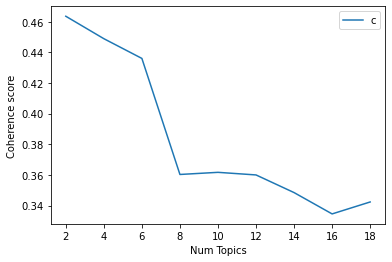

In [57]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4636
Num Topics = 4  has Coherence Value of 0.4489
Num Topics = 6  has Coherence Value of 0.436
Num Topics = 8  has Coherence Value of 0.3603
Num Topics = 10  has Coherence Value of 0.3617
Num Topics = 12  has Coherence Value of 0.36
Num Topics = 14  has Coherence Value of 0.3484
Num Topics = 16  has Coherence Value of 0.3345
Num Topics = 18  has Coherence Value of 0.3423


In [59]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.062*"company" + 0.051*"shareholder" + 0.041*"cut" + 0.039*"demand" + '
  '0.033*"seat" + 0.032*"lose" + 0.030*"climate" + 0.030*"day" + 0.029*"order" '
  '+ 0.027*"director"'),
 (1,
  '0.066*"climate" + 0.059*"use" + 0.044*"company" + 0.040*"action" + '
  '0.039*"world" + 0.035*"know" + 0.032*"work" + 0.027*"decade" + '
  '0.027*"exxon" + 0.024*"capture"'),
 (2,
  '0.058*"climate" + 0.029*"emission" + 0.023*"big" + 0.022*"chevron" + '
  '0.022*"change" + 0.021*"shell" + 0.020*"oil" + 0.020*"court" + 0.018*"fuel" '
  '+ 0.017*"board"'),
 (3,
  '0.090*"know" + 0.071*"point" + 0.052*"investment" + 0.049*"strategy" + '
  '0.044*"emission" + 0.041*"exxon" + 0.038*"show" + 0.035*"try" + '
  '0.035*"rise" + 0.033*"commit"')]


In [60]:
# Visualize the optimal topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.164281 -0.189378       1        1  44.105624
1      0.071326  0.316040       2        1  22.783551
0     -0.251417  0.016842       3        1  19.169524
3      0.344372 -0.143504       4        1  13.941301, topic_info=          Term          Freq          Total Category  logprob  loglift
81        know  83911.000000   83911.000000  Default  30.0000  30.0000
217        use  54017.000000   54017.000000  Default  29.0000  29.0000
631      point  39827.000000   39827.000000  Default  28.0000  28.0000
4      company  92156.000000   92156.000000  Default  27.0000  27.0000
142   emission  76552.000000   76552.000000  Default  26.0000  26.0000
...        ...           ...            ...      ...      ...      ...
143      exxon  22860.032416   55114.433011   Topic4  -3.1989   1.0903
142   emission  24686.927203   76552.408537   Topic4  -3.1220   0.8386
2057  facebook   4461.121322    6505.536360   Topic4  -4.8329   1.5931
7     lobbyist   4313.084076   13477.690100   Topic4  -4.8667   0.8309
2      climate   5942.662998  192139.386390   Topic4  -4.5462  -1.5057

[256 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.000616       action
0         2  0.950978       action
0         3  0.048365       action
0         4  0.000026       action
5048      1  0.013466  actionthank
...     ...       ...          ...
483       2  0.000056       yearly
483       4  0.999903       yearly
2311      1  0.999627    yesterday
2311      2  0.000242    yesterday
2311      4  0.000242    yesterday

[602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

### Finding the dominant topic in each sentence

In [62]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=ctext):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=ctext)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6093,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",Im thinking about writing a satire where the US Congress is blocked from taking action on the climate by a Senator who owns a coal company lives on a yacht and speaks daily with Exxon lobbyists but Im worried people will think its too on the nose
1,1,2.0,0.4282,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",no capitalists are the cause
2,2,2.0,0.7779,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",We started calling it climate change when Exxon Mobile did a very successful PR campaign in the s Apparently global warming is too specific and scary But Its global warming
3,3,2.0,0.6093,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",Im thinking about writing a satire where the US Congress is blocked from taking action on the climate by a Senator who owns a coal company lives on a yacht and speaks daily with Exxon lobbyists but Im worried people will think its too on the nose
4,4,2.0,0.4282,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",no capitalists are the cause


### Find the most representative document for each topic

In [63]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9580,"company, shareholder, cut, demand, seat, lose, climate, day, order, director",From CNN Activist investor ousts at least two Exxon directors in historic win for proclimate campaign Activist investor ousts at least two Exxon directors in historic win for proclimate campaign
1,1.0,0.9641,"climate, use, company, action, world, know, work, decade, exxon, capture",I am near speechless An Exxon official admitting on camera how the company works to prevent effective climate action by using third party whipping boys so no one knows its them These recordings should be played on every TV station in the world
2,2.0,0.9721,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",Theres man made climate change done by fossil fuels then theres man made climate change done by space lasersConveniently the space laser discourse sprung up around the time climate change got worse Now ask yourself if Exxon etc Would benefit from shifting blame
3,3.0,0.9462,"know, point, investment, strategy, emission, exxon, show, try, rise, commit",Exxons own assessment of its 210 billion investment strategy shows yearly emissions rising by Exxon knew thenExxon knows nowExxon is committing Ecocide


### Topic distribution across documents

In [64]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(4)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",35615.0,0.1470
1.0,2.0,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",52645.0,0.2173
2.0,2.0,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",131824.0,0.5441
3.0,2.0,"climate, emission, big, chevron, change, shell, oil, court, fuel, board",22198.0,0.0916
